# This notebook contains code to check which model performs better on given data

### Import data

The main dataset was loaded from [Kaggle](https://www.kaggle.com/datasets/nathanlauga/nba-games/data). However, I added 2 extra files with season schedule (`season_schedule.csv`) and Play-Off teams for given seasons (`play_off_teams.csv`).

#### Games information

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

df_games = pd.read_csv('data/games.csv').drop(["TEAM_ID_home", "TEAM_ID_away"], axis=1)
df_games = df_games.loc[df_games["SEASON"] >= 2004]

scaler = MinMaxScaler()
cols_to_norm = ["HOME_TEAM_ID", "VISITOR_TEAM_ID"]
df_games.loc[:, cols_to_norm] = scaler.fit_transform(df_games.loc[:, cols_to_norm])
df_games

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,0.103448,0.758621,2022,126.0,0.484,0.926,0.382,25.0,46.0,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,0.862069,0.931034,2022,120.0,0.488,0.952,0.457,16.0,40.0,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,0.068966,0.413793,2022,114.0,0.482,0.786,0.313,22.0,37.0,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,0.620690,0.965517,2022,113.0,0.441,0.909,0.297,27.0,49.0,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,0.000000,0.137931,2022,108.0,0.429,1.000,0.378,22.0,47.0,110.0,0.500,0.773,0.292,20.0,47.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26646,2014-10-06,11400007,Final,0.000000,0.103448,2014,93.0,0.419,0.821,0.421,24.0,50.0,87.0,0.366,0.643,0.375,17.0,43.0,1
26647,2014-10-06,11400004,Final,0.137931,0.931034,2014,81.0,0.338,0.719,0.381,18.0,40.0,85.0,0.411,0.636,0.267,17.0,47.0,0
26648,2014-10-06,11400005,Final,0.344828,0.206897,2014,98.0,0.448,0.682,0.500,29.0,45.0,95.0,0.387,0.659,0.500,19.0,43.0,1
26649,2014-10-05,11400002,Final,0.827586,0.724138,2014,99.0,0.440,0.771,0.333,21.0,30.0,94.0,0.469,0.725,0.385,18.0,45.0,1


#### Teams information

In [2]:
df_teams = pd.read_csv('data/teams.csv')
df_teams.loc[:, ["TEAM_ID"]] = scaler.fit_transform(df_teams.loc[:, ["TEAM_ID"]])
df_teams.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,0.000000,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,0.034483,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,0.103448,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,0.137931,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,0.172414,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


#### Seasons dates

In [3]:
season_schedule = pd.read_csv("data/season_schedule.csv")
"""
SEASON: start year of the season, i.e. season 2004 is season 2004-2005
START: beginning date of regular mathces
END: beginning date of play-off
"""
season_schedule.head()

,SEASON,START,END
0,2004,2004-11-02,2005-04-23
1,2005,2005-11-01,2006-04-22
2,2006,2006-10-31,2007-04-21
3,2007,2007-10-30,2008-04-19
4,2008,2008-10-28,2009-04-18


In [4]:
some_list = [int, list, str]

a = 2

if type(a) in some_list:
    print("a")

a


### Test different models for all seasons

In [5]:
useful_columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID',
                    'FG_PCT_home', 'FT_PCT_home',
                    'FG3_PCT_home', 'AST_home', 'REB_home',
                    'FG_PCT_away', 'FT_PCT_away',
                    'FG3_PCT_away', 'AST_away', 'REB_away',
                    'HOME_TEAM_WINS']

# hyper-parameters for models
dec_tree_params = {'criterion': ['gini', 'entropy'],
                   'splitter': ['best', 'random']}
rand_tree_params = {'criterion': ['gini', 'entropy'],
                    'n_estimators': [i for i in range(100, 501, 100)]}
svc_params = {'kernel': ['poly', 'rbf'],
              'degree': [i for i in range(3, 6)]}
knn_params = {'n_neighbors': [i for i in range(3, 6)],
              'weights': ['uniform', 'distance']}
nb_params = {'var_smoothing': np.linspace(1e-5, 1, 10)}
logreg_params = {'penalty': ['l2', None]}

# models to seelct from
models = {LogisticRegression: ('LogReg', logreg_params),
                 DecisionTreeClassifier: ('DecTree', dec_tree_params),
                 RandomForestClassifier: ('RandTree', rand_tree_params),
                 SVC: ('SVC', svc_params),
                 KNeighborsClassifier: ('KNN', knn_params),
                 GaussianNB: ('NaiveBayes', nb_params)}

metrics = {'accuracy': accuracy_score, 'precision': precision_score, 'recall': recall_score, 'f1': f1_score}
test_results = {model: {metric: [] for metric in metrics.keys()} for model in models.keys()}

# iterate over data for each season and try different model
# to select which model performs better on average
for row in tqdm(season_schedule.iterrows()):
    season, _, __ = row[1].values
    X = df_games.loc[df_games["SEASON"] == season, useful_columns]
    cols_to_norm = ['AST_home', 'REB_home', 'AST_away', 'REB_away']
    
    X_train, X_test, y_train, y_test = train_test_split(X.drop(["HOME_TEAM_WINS"], axis=1),
                                                        X["HOME_TEAM_WINS"],
                                                        test_size=0.3,
                                                        random_state=42)
    X_train.loc[:, cols_to_norm] = scaler.fit_transform(X_train.loc[:, cols_to_norm])
    X_test.loc[:, cols_to_norm] = scaler.transform(X_test.loc[:, cols_to_norm])
    
    for model in models.keys():
        current_model = model()
        model_params = models[model][1]
        current_model = GridSearchCV(estimator=current_model,
                                         cv=3,
                                         param_grid=model_params,
                                         scoring='accuracy')
        current_model.fit(X_train, y_train)
        
        y_pred = current_model.predict(X_test)
        for metric_name, metric in metrics.items():
            test_results[model][metric_name].append(metric(y_test, y_pred))


13it [04:59, 22.63s/it]c:\Users\bugue\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
16it [06:04, 22.14s/it]c:\Users\bugue\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

### Plot bar diagram with average metrics results for each model

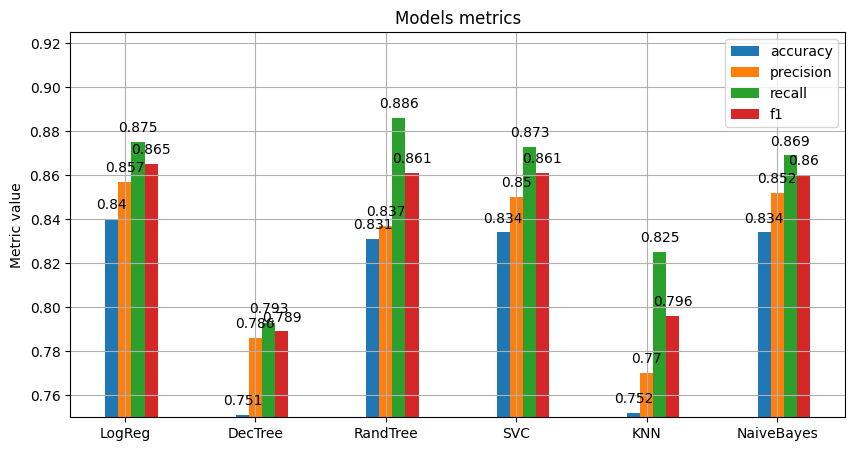

In [6]:
all_results = {metric_name: [] for metric_name in metrics.keys()}

for model, results in test_results.items():
    for metric, value in results.items():
        all_results[metric].append(np.array(value).mean())

x_loc = np.arange(len(models))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10, 5))

for attribute, measurement in all_results.items():
    offset = width * multiplier
    rects = ax.bar(x_loc + offset, np.round(measurement, 3), width, label=attribute)
    ax.bar_label(rects, padding=5)
    multiplier += 1

ax.set_ylabel('Metric value')
ax.set_title('Models metrics')
ax.set_xticks(x_loc + width, [v[0] for v in models.values()])
ax.legend()
ax.grid()
ax.set_ylim(0.75, 0.925)

plt.show()

#### We can see that *Decision Tree* and *KNN* showed worst results in all metrics, hence we immediately drop them. *Random Decision Tree* demonstrated highest `recall` score compared to all models, but it showed worse results in other metrics, so we cannot immediately pick this model either. On average it looks like *Logistic regression* model showed one of the best results, therefore, let us use this model for the predictions.